In [89]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [90]:
from fastai.text import *

## Load in Dataset

In [91]:
path = Path('data')
path.ls()

[PosixPath('data/title_labeled.csv'),
 PosixPath('data/title_lm_data.csv'),
 PosixPath('data/data_lm.pkl'),
 PosixPath('data/data_classifier.pkl'),
 PosixPath('data/models'),
 PosixPath('data/.ipynb_checkpoints')]

In [92]:
bs=10

In [93]:
data = (TextList.from_csv(path, './title_labeled.csv', cols='text')
                .split_from_df(col=2)
                .label_from_df(cols=0)
                .databunch(bs=bs))

In [94]:
data.show_batch()

text,target
xxbos xxmaj xxunk xxmaj xxunk xxmaj xxunk xxmaj xxunk xxmaj xxunk xxmaj xxunk xxmaj xxunk xxmaj xxunk xxmaj apollo xxunk xxmaj xxunk,True
xxbos xxmaj xxunk xxmaj xxunk xxmaj xxunk xxmaj xxunk xxmaj xxunk xxmaj xxunk xxmaj xxunk xxmaj xxunk xxmaj xxunk xxunk xxmaj space,False
xxbos xxmaj xxunk xxmaj space xxmaj station xxmaj crew xxmaj xxunk a xxmaj xxunk xxmaj from xxmaj xxunk,True
xxbos xxmaj space xxmaj station xxmaj crew xxmaj xxunk xxunk xxmaj xxunk of the xxmaj xxunk xxmaj xxunk,False
xxbos xxmaj xxunk xxmaj xxunk of xxmaj xxunk xxmaj xxunk xxmaj xxunk in the xxmaj xxunk xxmaj xxunk,False


# Train Langauge Model

In [95]:
data_lm = (TextList.from_csv(path, './title_lm_data.csv', cols='text')
                .split_from_df(col=2)
                .label_from_df(cols=0)
                .label_for_lm()          
                .databunch(bs=bs))
data_lm.save('data_lm.pkl')

In [96]:
data_lm = load_data(path, 'data_lm.pkl', bs=bs)

In [97]:
data_lm.show_batch()

idx,text
0,xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxbos xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxbos xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxbos xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk
1,xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxbos xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxbos xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxbos xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxbos xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxbos
2,xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxbos xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxbos xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxbos xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxbos
3,xxunk xxunk xxbos xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxbos xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxbos xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxbos xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxbos xxunk xxunk xxunk xxunk
4,xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxbos xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxbos xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxbos xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxbos xxunk xxunk xxunk


In [100]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

In [102]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


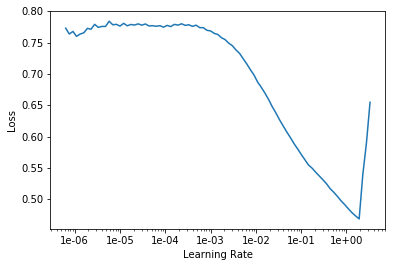

In [103]:
learn.recorder.plot()

In [104]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.759446,0.579268,0.934286,00:00


In [105]:
learn.save('fit_head')

In [106]:
learn.load('fit_head');

In [107]:
learn.unfreeze()

In [108]:
learn.fit_one_cycle(3, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.597650,1.751260,0.341429,00:00
1,0.616908,0.524517,0.935714,00:00
2,0.580963,0.549829,0.935714,00:00


In [109]:
learn.save('fine_tuned')

In [110]:
learn.load('fine_tuned');

In [121]:
TEXT = "SpaceX Successfully Landed on the"
N_WORDS = 10
N_SENTENCES = 1

In [122]:
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

SpaceX Successfully Landed on the Space Station Station in Space


### Save the Encoder
The first half of the Language Model that Understands the Sentence 

In [123]:
learn.save_encoder('fine_tuned_enc')

# Train Classifier Model

Important to load in the language model vocab

In [124]:
data_classifier = (TextList.from_csv(path, './title_labeled.csv', cols='text', vocab=data_lm.vocab)
                .split_from_df(col=2)
                .label_from_df(cols=0)
                .databunch(bs=bs))
data_classifier.save('data_classifier.pkl')

In [125]:
data_classifier = load_data(path, 'data_classifier.pkl', bs=bs)

In [126]:
data_classifier.show_batch()

text,target
xxbos xxmaj xxunk xxmaj xxunk xxmaj xxunk xxmaj xxunk xxmaj xxunk xxmaj xxunk xxmaj xxunk xxmaj xxunk xxmaj xxunk xxunk xxmaj space,False
xxbos xxmaj xxunk xxmaj xxunk xxmaj xxunk xxmaj xxunk xxmaj xxunk xxmaj xxunk xxmaj xxunk xxmaj xxunk xxmaj apollo xxunk xxmaj xxunk,True
xxbos xxmaj xxunk xxmaj xxunk of xxmaj xxunk xxmaj xxunk xxmaj xxunk in the xxmaj xxunk xxmaj xxunk,False
xxbos xxmaj space xxmaj station xxmaj crew xxmaj xxunk an xxmaj xxunk of the xxmaj xxunk xxmaj xxunk,False
xxbos xxmaj xxunk and xxmaj xxunk xxmaj xxunk xxmaj xxunk xxunk the xxmaj xxunk xxup xxunk xxmaj xxunk,False


In [127]:
learn = text_classifier_learner(data_classifier, AWD_LSTM, drop_mult=0.5)
learn.load_encoder('fine_tuned_enc');

In [128]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


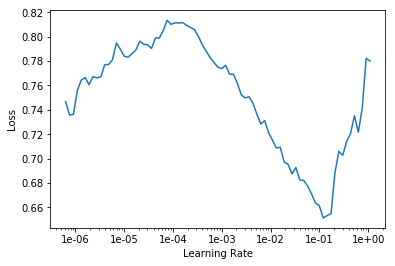

In [129]:
learn.recorder.plot()

In [130]:
learn.fit_one_cycle(10, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.772342,0.682083,0.631579,00:01
1,0.745544,0.710077,0.473684,00:01
2,0.794056,0.734455,0.210526,00:01
3,0.730677,0.735498,0.473684,00:01
4,0.685505,0.735722,0.473684,00:01
5,0.637434,0.725716,0.578947,00:01
6,0.628784,0.739877,0.578947,00:01
7,0.602580,0.761748,0.473684,00:01
8,0.599563,0.762421,0.473684,00:01
9,0.563547,0.759088,0.473684,00:01


In [131]:
learn.save('first')

In [132]:
learn.load('first');

In [133]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.500094,0.967800,0.473684,00:01


In [134]:
learn.save('second')

In [135]:
learn.load('second');

In [136]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.551699,0.747191,0.631579,00:01


In [137]:
learn.save('third')

In [138]:
learn.load('third');

In [139]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.489065,0.768406,0.631579,00:01
1,0.468113,0.773160,0.631579,00:01


In [140]:
learn.save('fourth')

In [141]:
learn.load('fourth');

In [142]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.537444,0.726567,0.578947,00:01
1,0.515003,0.712849,0.578947,00:00


In [143]:
learn.predict("SpaceX Dragon Launched")

(Category True, tensor(1), tensor([0.4425, 0.5575]))

In [144]:
learn.predict("Dark Matter is Discovered")

(Category True, tensor(1), tensor([0.3636, 0.6364]))

In [145]:
learn.predict("Boring Stuff")

(Category False, tensor(0), tensor([0.6768, 0.3232]))

In [158]:
learn.predict("California is seen from Space")

(Category False, tensor(0), tensor([0.9762, 0.0238]))

In [154]:
learn.predict("Station Crew Sees Typhoon from Space")

(Category False, tensor(0), tensor([0.9983, 0.0017]))

In [155]:
learn.predict("Apollo 57 Launches for the first time")

(Category True, tensor(1), tensor([0.0606, 0.9394]))

In [161]:
learn.predict("Biology is used in space")

(Category False, tensor(0), tensor([0.9469, 0.0531]))